In [1]:
!pip install s2cloudless

In [2]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=pQ7Qur56oyerFEsN2IjaUN-md4kPiWsDKAS1_PiL2C8&tc=SSjsYuQ49Bx1POVAtZHi9U_L09NME57wuFHbCT-avDk&cc=lXtawRww_sgbWyuyca3L9jMOFgDX_56HIOrdmAbOj3o

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BVB-KHwid-OKrX-R3vBalJHxSa0zNtl_r9LmhYJmeRMZTx7lLHQ_jo

Successfully saved authorization token.


In [3]:
import os
import pandas as pd
from enum import Enum
from datetime import datetime, timedelta
import calendar
from math import pi
from typing import Union
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def convert_to_df(collection, selected_bands,area,resize):

  df = pd.DataFrame(collection.select(selected_bands).getRegion(area, resize).getInfo() ) # Flattens the Collection Object

  headers = df.iloc[0]
  df = pd.DataFrame(df.values[1:], columns=headers)
  df['datetime'] = pd.to_datetime(df['time'], unit='ms')
  df = df.sort_values('datetime')

  for band in selected_bands:
      df[band] = pd.to_numeric(df[band], errors='coerce')

  return df

def doy(img):
  doy = ee.Date(img.get('system:time_start')).getRelative('day', 'year')
  return img.set('doy', doy)


In [5]:
def window_composites(collection, start_date, end_date, interval, increment, reducer):
  interval = interval
  increment = increment
  start = start_date

  startDate = ee.Date(start);
  secondDate = startDate.advance(interval, increment).millis()
  increase = secondDate.subtract(startDate.millis())
  date_seq = ee.List.sequence(startDate.millis(), ee.Date(end_date).millis(), increase);

  col = date_seq.map(lambda date: collection.filterDate(ee.Date(date), ee.Date(date).advance(interval, increment)).reduce(reducer).set('system:time_start',ee.Date(date).millis()))
  col = ee.ImageCollection.fromImages(col)

  return col

In [6]:

def rm_null(image):
  return image.set('count', image.bandNames().length())

# Classes

In [12]:

class band_maths():
    '''
    one should aim to use surface reflectance data for the band maths where available
    https://www.indexdatabase.de/db < database of indices and the associated band maths
    '''
    def __init__(self, satellite):
        self.satellite = satellite

    def ndvi(self,image):
        # fake19 = ee.Image.constant(0).rename('NDVI')
        # image = image.addBands(srcImg=image, overwrite=True).copyProperties(image)
        # image = image.addBands(ee.Image.constant(0).rename('NDVI'), overwrite = True)
        if  self.satellite == 'sentinel2':
            return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'), overwrite=True) # B8A is Red Edge 4 , B8 is NIR .. https://forum.step.esa.int/t/nir-sentinel-2/12342

    def all_bands(self,image):
        bands = image.map(self.ndvi)

        return bands

In [13]:
class select_satellite(Enum):

    sentinel2_cloudless = "COPERNICUS/S2_SR"


class image_collection():
    def __init__(self, satellite):
        self.satellite = satellite

    @staticmethod
    def aoi(aoi):
        return ee.Geometry.Polygon(aoi)

    @staticmethod
    def timestamplist(image_collection):
        return (image_collection.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d)))
                 .getInfo())

    def get_collection(self, aoi, startDate, endDate, cloud_cover):

        if self.satellite == 'sentinel2_cloudless':
            satName = select_satellite[self.satellite].value
            s2_sr_col = (ee.ImageCollection(satName)
                        .filterBounds(aoi)
                        .filterDate(ee.Date(startDate),ee.Date(endDate))
                        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", ee.Number(cloud_cover))
                        .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
                        .sort('date'))
            s2_sr_col = s2_sr_col.map(lambda image: image.clip(aoi))

            # Import and filter s2cloudless.
            s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
                .filterBounds(aoi)
                .filterDate(startDate, endDate))
            s2_cloudless_col = s2_cloudless_col.map(lambda image: image.clip(aoi))

            # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
            return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
                'primary': s2_sr_col,
                'secondary': s2_cloudless_col,
                'condition': ee.Filter.equals(**{
                    'leftField': 'system:index',
                    'rightField': 'system:index'
                })
            }))


In [14]:
class cloud_mask:
    def __init__(self, CLD_PRB_THRESH, NIR_DRK_THRESH, CLD_PRJ_DIST, BUFFER, SCALE) -> None:
        # self.img = IMG
        # self.sattlite = SATELLITE
        self.cld_prb_thresh = CLD_PRB_THRESH
        self.nir_drk_thresh = NIR_DRK_THRESH
        self.cld_prj_dist = CLD_PRJ_DIST
        self.buffer = BUFFER
        self.mask = SCALE # this is removes small cloud-shadow patches and dilate remaining pixels by BUFFER input, 20m scale quicker calc.

    def add_cloud_bands(self, img):
        cld_prb = ee.Image(img.get('s2cloudless')).select('probability')
        is_cloud = cld_prb.gt(self.cld_prb_thresh).rename('clouds')
        return img.addBands(ee.Image([cld_prb, is_cloud]))

    def add_shadow_bands(self, img):
        not_water = img.select('SCL').neq(6)
        SR_BAND_SCALE = 1e4
        dark_pixels = img.select('B8').lt(self.nir_drk_thresh*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')
        # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
        shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

        # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
        cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, self.cld_prj_dist*10)
            .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
            .select('distance')
            .mask()
            .rename('cloud_transform'))

        # Identify the intersection of dark pixels with cloud shadow projection.
        shadows = cld_proj.multiply(dark_pixels).rename('shadows')
        # Add dark pixels, cloud projection, and identified shadows as image bands.
        return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

    def add_cld_shdw_mask(self, img):
        img_cloud = self.add_cloud_bands(img) #
        img_cloud_shadow = self.add_shadow_bands(img_cloud)
        is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)
        is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(self.buffer*2/20)
            .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
            .rename('cloudmask'))
        return img_cloud_shadow.addBands(is_cld_shdw)

    def apply_cld_shdw_mask(self, img):
        not_cld_shdw = img.select('cloudmask').Not()
        # return img.select('B.*').updateMask(not_cld_shdw)
        return img.updateMask(not_cld_shdw)

    def apply_to_collection(self, collection, composite=False):
        if composite:
            return collection.map(self.add_cld_shdw_mask).map(self.apply_cld_shdw_mask).median()
        return collection.map(self.add_cld_shdw_mask).map(self.apply_cld_shdw_mask)


In [15]:
class harmonicModel():

    def __init__(self,freqs):
        self.freqs = freqs
        self.hldrs = self.holders()

    def holders(self):
        rng = list(range(1,self.freqs+1))
        cosNames = ee.List([f'cos_{_}' for _ in rng])
        sinNames = ee.List([f'sin_{_}' for _ in rng])
        independents = ee.List(['constant', 't']).cat(cosNames).cat(sinNames)

        return {'frequencies':rng,'cosNames':cosNames,'sinNames':sinNames,'independents':independents}

    def bands_2_add(self,img):
        from math import pi

        img = img.addBands(ee.Image(1))
        date = img.date()
        years = date.difference(ee.Date('1970-01-01'), 'year')
        timeRadians = ee.Image(years.multiply(2 * pi))
        return img.addBands(timeRadians.rename('t').float())

    def addHarmonics(self, img):
        hlds = self.hldrs
        # img = harmonicLandsat.first()
        frequencies = ee.Image.constant(hlds['frequencies'])
        time = ee.Image(img).select('t')
        cosines = time.multiply(frequencies).cos().rename(hlds['cosNames'])
        sines = time.multiply(frequencies).sin().rename(hlds['sinNames'])
        return img.addBands(cosines).addBands(sines)

# CODE

# Input your area of interest , make sure the polygon is closed

https://www.keene.edu/campus/maps/tool/


In [50]:
usfarm = [
      [
        -90.6971821,
        42.2403156
      ],
      [
        -90.697805,
        42.2368683
      ],
      [
        -90.6996307,
        42.2368683
      ],
      [
        -90.6993944,
        42.2330713
      ],
      [
        -90.6946691,
        42.233262
      ],
      [
        -90.6948624,
        42.2402362
      ],
      [
        -90.6971821,
        42.2403156
      ]
    ]


In [51]:
sc = image_collection('sentinel2_cloudless')
sm = band_maths('sentinel2')


# aoi = tumsong[5]
aoi = usfarm
area = sc.aoi(aoi)

centroid = area.centroid()

CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50
SCALE = 10
CLOUD_COVER = 80

cm = cloud_mask(CLD_PRB_THRESH = CLD_PRB_THRESH,NIR_DRK_THRESH = NIR_DRK_THRESH,\
                CLD_PRJ_DIST = CLD_PRJ_DIST, BUFFER = BUFFER, SCALE = SCALE)

hm = harmonicModel(3)



In [52]:
SENTINEL_COLLECTION = sc.get_collection(area, '2017-01-01','2023-08-24', 10)
SENTINEL_COLLECTION = sm.all_bands(SENTINEL_COLLECTION)


list_of_bands = SENTINEL_COLLECTION.first().bandNames().getInfo()
SENTINEL_COLLECTION = cm.apply_to_collection(SENTINEL_COLLECTION,False)

SENTINEL_COLLECTION = SENTINEL_COLLECTION.select(['MSK_.*','ND.*'])
harmonicSentinel = SENTINEL_COLLECTION.map(hm.bands_2_add).map(hm.addHarmonics)
dependent = 'NDVI'

harmonicTrend = harmonicSentinel.select(hm.hldrs['independents'].add(dependent)).reduce(ee.Reducer.linearRegression(hm.hldrs['independents'].length(), 1))
harmonicTrendCoefficients = harmonicTrend.select('coefficients').arrayProject([0]).arrayFlatten([hm.hldrs['independents']])
harmonicSentinel = harmonicSentinel.map(lambda img: img.addBands(img.select(hm.hldrs['independents']).multiply(harmonicTrendCoefficients).reduce('sum').rename('fitted')))

sentWindComp = window_composites(harmonicSentinel,'2017-01-01','2023-08-24', 7, 'day', ee.Reducer.percentile([95]) )

sentWindComp = sentWindComp.map(rm_null)
sentWindComp = sentWindComp.filter(ee.Filter.neq('count',0))

In [53]:
sentWindComp = sentWindComp.map(rm_null)
sentWindComp = sentWindComp.filter(ee.Filter.neq('count',0))

#Please note that this next cell takes a minute or two to run

In [54]:
resizer = 10 # < resolution, use if google freaks out re datapoints. or iterate

dfs = []
map_values = []

for i in ['NDVI_p95','fitted_p95']:

  s2_df = convert_to_df(sentWindComp,[i],area,resizer)
  map_values.append(s2_df)

  s2_df = s2_df[s2_df[i] > 0] # Remove negative NDVI (prob WATER bodies)

  if i == 'NDVI_p95':
    s2_df = s2_df.groupby('datetime').agg(
        mNDVI=pd.NamedAgg(column="NDVI_p95", aggfunc="mean"),
        cNDVI=pd.NamedAgg(column="NDVI_p95", aggfunc="count"),
        )

  else:
    s2_df = s2_df.groupby('datetime').agg(
        mfitted=pd.NamedAgg(column="fitted_p95", aggfunc="mean"),
        cfitted=pd.NamedAgg(column="fitted_p95", aggfunc="count"),
        )

  s2_df.reset_index(inplace = True)
  dfs.append(s2_df)




# Collect up the dataframes

In [55]:
s2_df = dfs[0].merge(dfs[1])

In [56]:
map_values = map_values[0].merge(map_values[1])

In [57]:
s2_df.cNDVI.min(), s2_df.cNDVI.mean()

(18, 2833.364864864865)

In [58]:
s2_df = s2_df[s2_df.cNDVI>1000] # REMOVE THE IMAGES THAT HAVE TOO FEW PIXELS

In [59]:
s2_df.drop(['cfitted','cNDVI'],axis = 1,inplace = True)
s2_df = s2_df.melt('datetime')

<ipython-input-59-eefe4d20db72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# GRAPHS
TIMESERIES

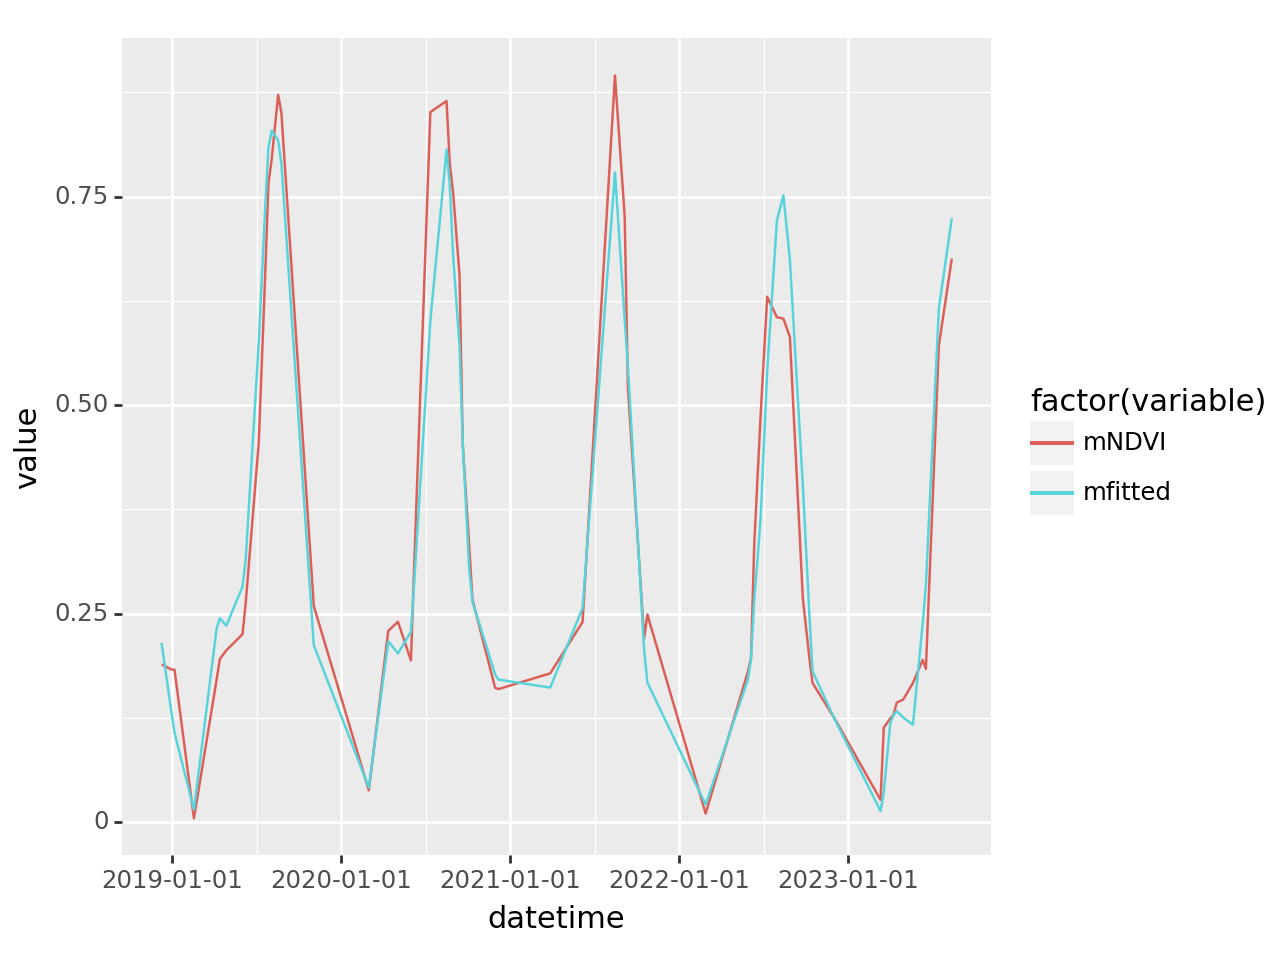

<Figure Size: (640 x 480)>

In [60]:
(ggplot(s2_df, \
        aes('datetime','value',color="factor(variable)"))
      + geom_line()
)

# Fast HeatMap
Remeber projections wont be correct but values will be

In [61]:
s2_df.datetime.unique() #< These are the dates you can use

array(['2018-12-09T00:00:00.000000000', '2018-12-30T00:00:00.000000000',
       '2019-01-06T00:00:00.000000000', '2019-02-17T00:00:00.000000000',
       '2019-04-07T00:00:00.000000000', '2019-04-14T00:00:00.000000000',
       '2019-04-28T00:00:00.000000000', '2019-06-02T00:00:00.000000000',
       '2019-06-09T00:00:00.000000000', '2019-07-07T00:00:00.000000000',
       '2019-07-21T00:00:00.000000000', '2019-07-28T00:00:00.000000000',
       '2019-08-04T00:00:00.000000000', '2019-08-18T00:00:00.000000000',
       '2019-08-25T00:00:00.000000000', '2019-11-03T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-12T00:00:00.000000000',
       '2020-05-03T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
       '2020-06-07T00:00:00.000000000', '2020-07-12T00:00:00.000000000',
       '2020-08-16T00:00:00.000000000', '2020-08-23T00:00:00.000000000',
       '2020-08-30T00:00:00.000000000', '2020-09-13T00:00:00.000000000',
       '2020-09-20T00:00:00.000000000', '2020-10-04

In [62]:
DATE = '2023-06-11' # < Pick a Date
VAR = 'NDVI_p95' # < or fitted_p95 which is derived from the harmonic model
map2plot  = map_values[map_values.datetime == DATE].pivot('latitude','longitude',VAR)

<ipython-input-62-0f08ecf0cc0d>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
<ipython-input-62-0f08ecf0cc0d>:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<ipython-input-62-0f08ecf0cc0d>:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


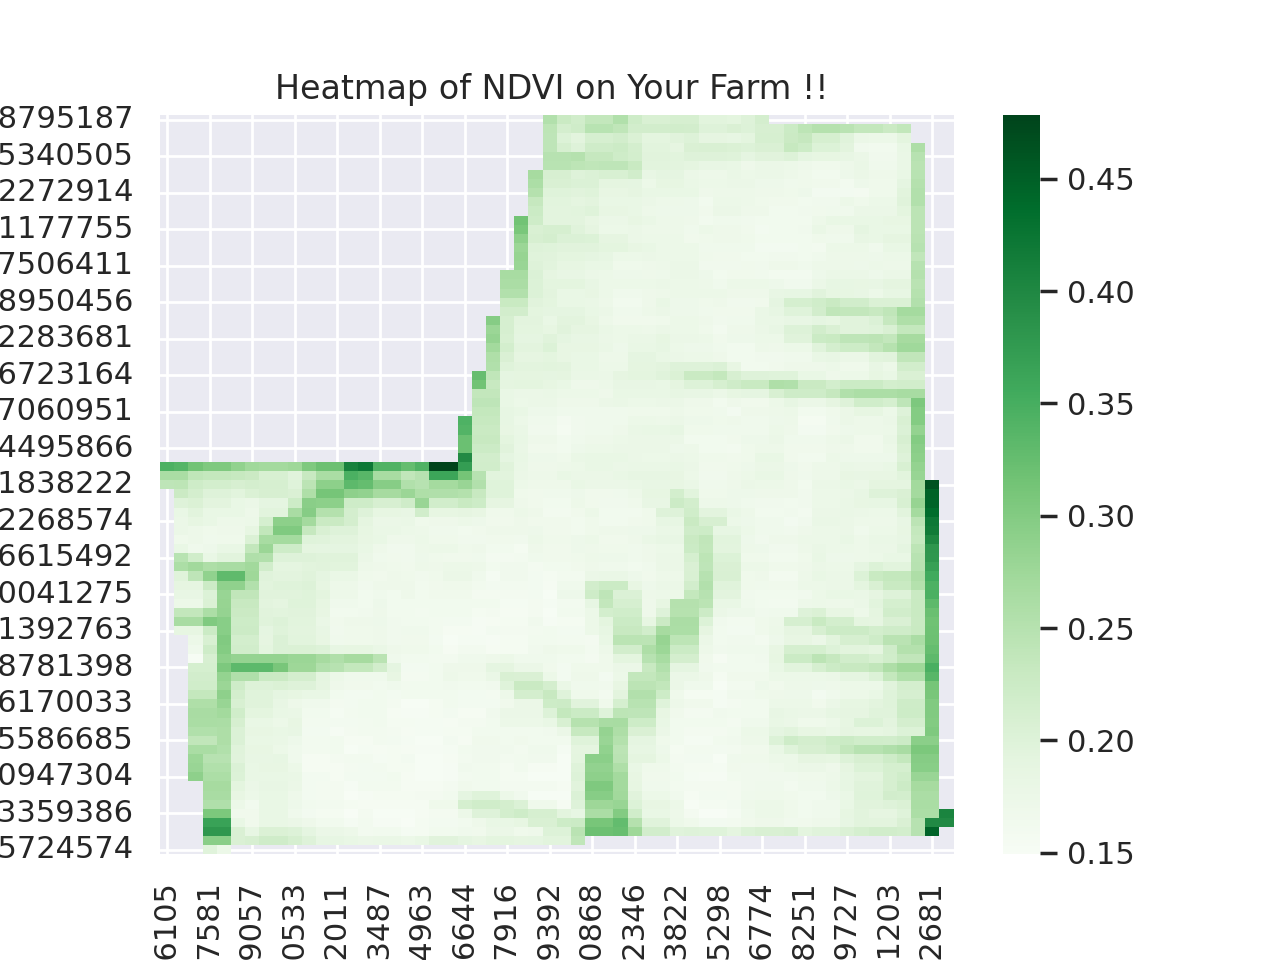

In [63]:
sns.set()
ax = sns.heatmap(map2plot,cmap = 'Greens', square = False)
ax.invert_yaxis()
plt.title("Heatmap of NDVI on Your Farm !! ")
plt.show()

# OR iterate over some dates

<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


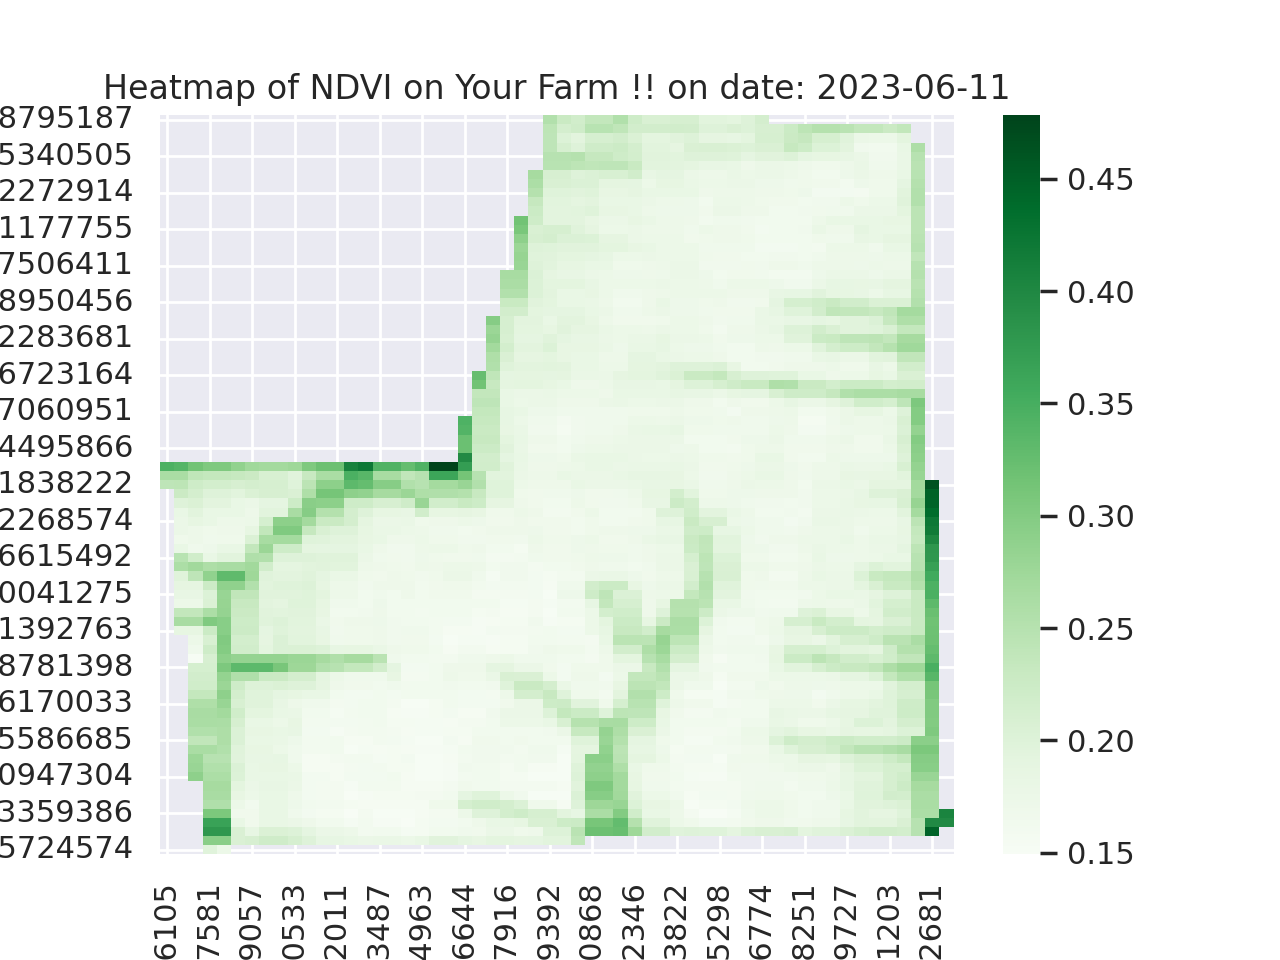

<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


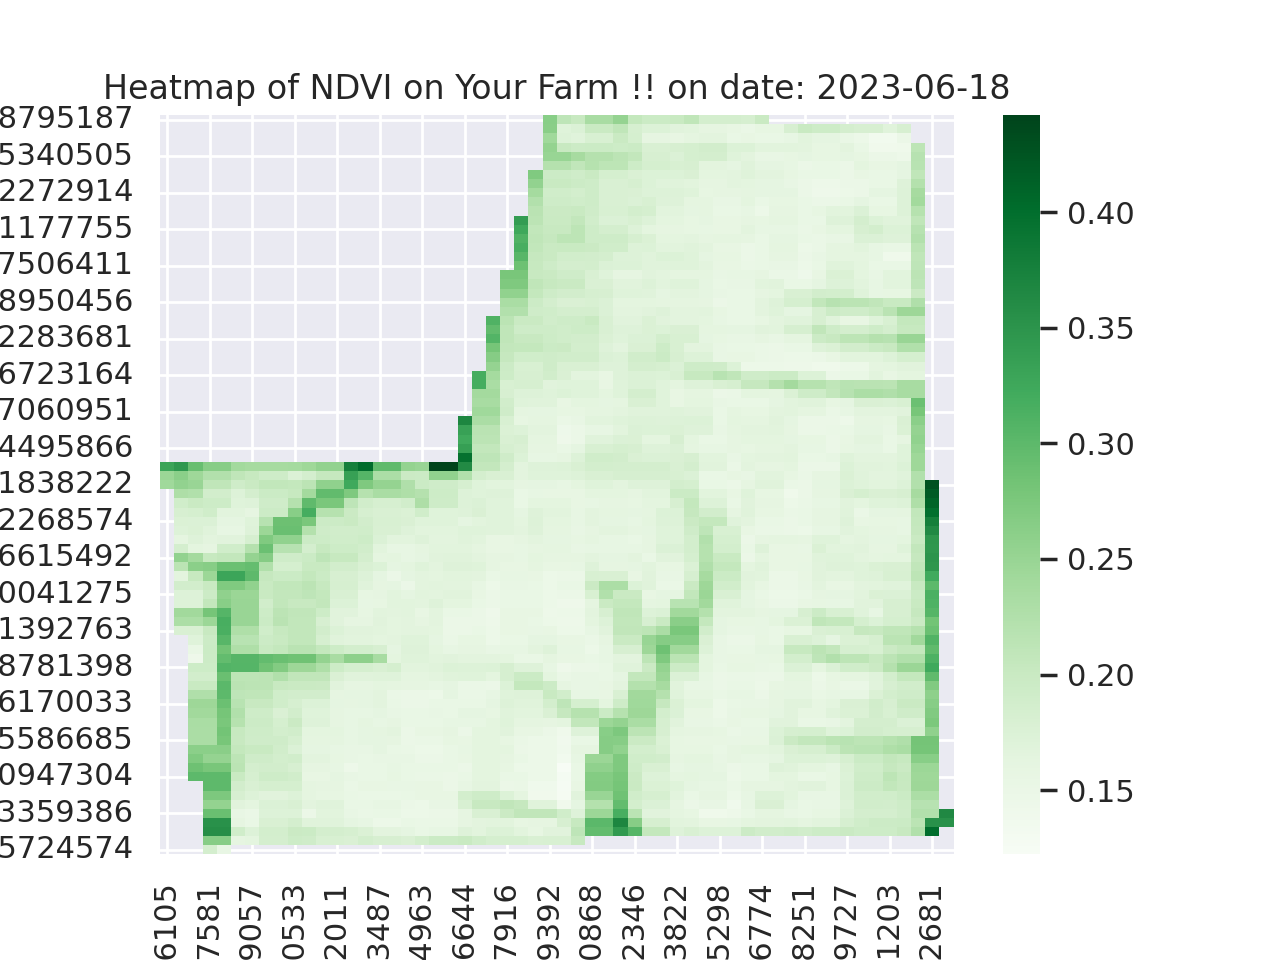

<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


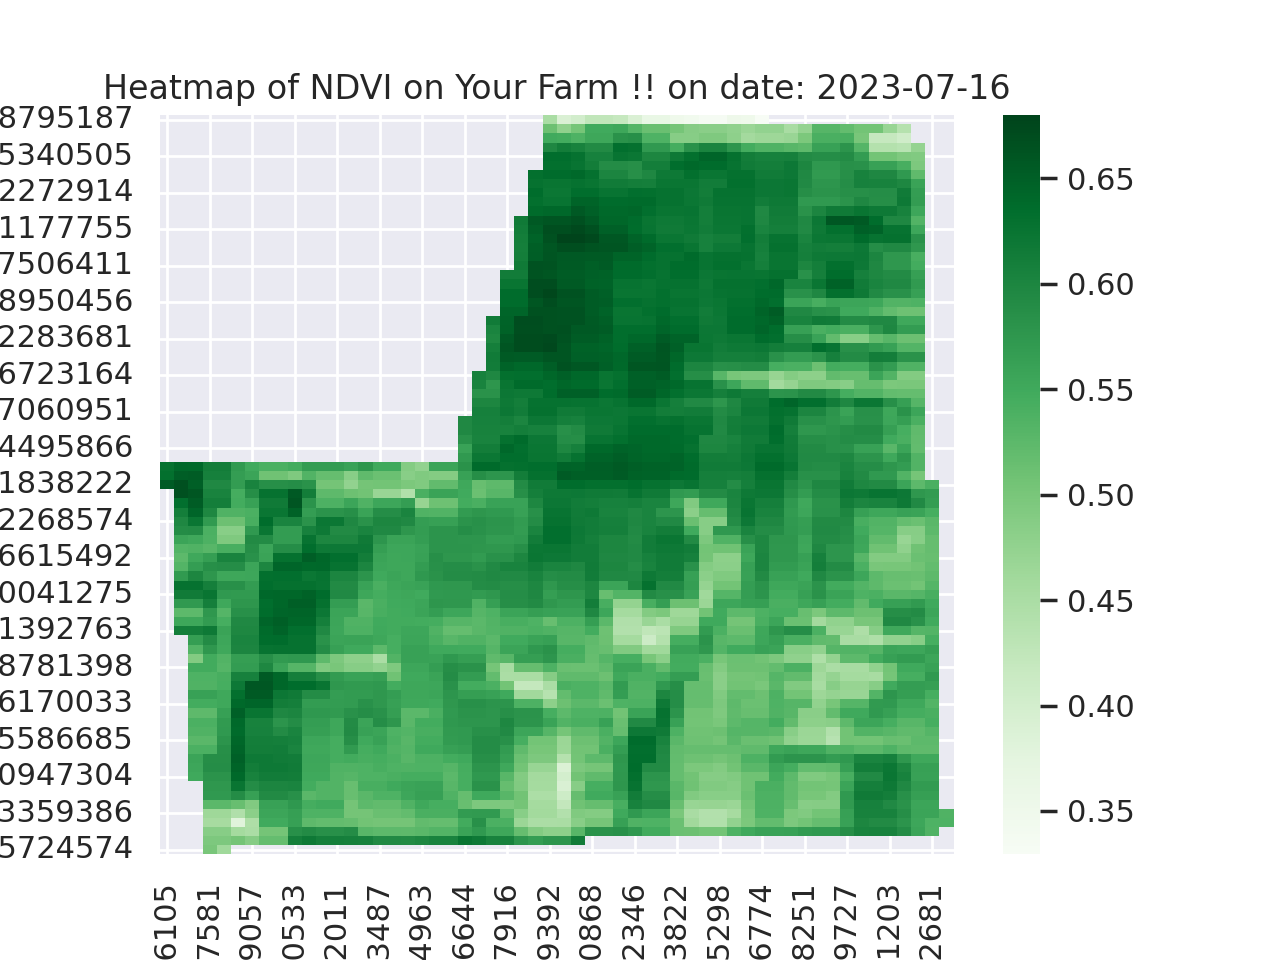

<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
<ipython-input-65-22ae55a69ec6>:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


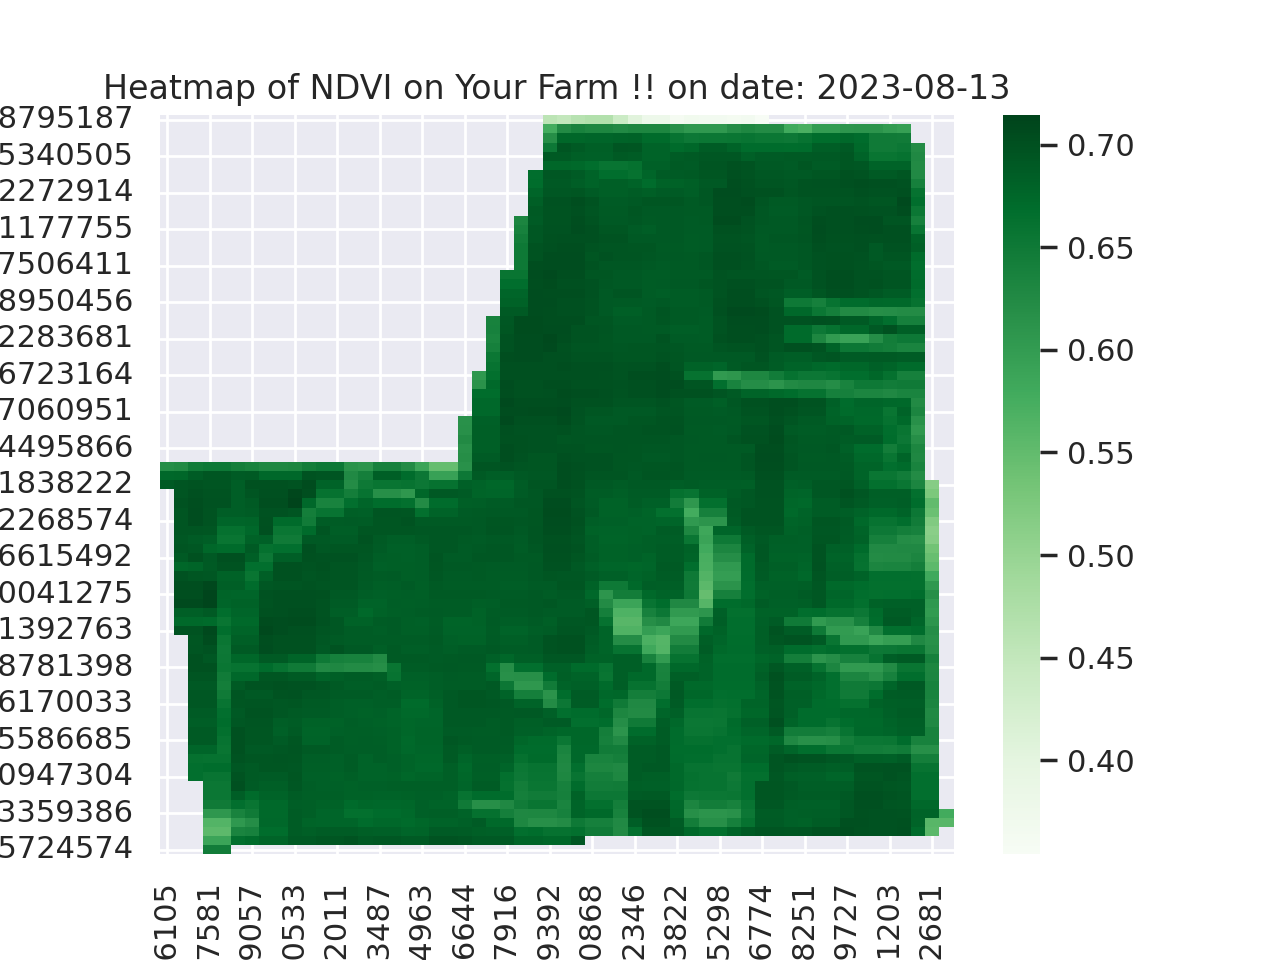

In [65]:
DATES = ['2023-06-11','2023-06-18', '2023-07-16', '2023-08-13']
VAR = 'NDVI_p95' # < or fitted_p95 which is derived from the harmonic model

for i in DATES:
  map2plot  = map_values[map_values.datetime == i].pivot('latitude','longitude',VAR)
  sns.set()
  ax = sns.heatmap(map2plot,cmap = 'Greens', square = False)
  ax.invert_yaxis()
  plt.title(f"Heatmap of NDVI on Your Farm !! on date: {i}")
  plt.show()